# 자연어와 단어의 분산표현

이 파일에서는 컴퓨터에 언어를 이해시키는 것이 어떤 것인지, 그리고 어떤 접근법이 존재하는지를 중심으로 고찰해본다. 특히 딥러닝 등장 이전의 방법에 대해 자세히 잘펴본다. 다음 ch3 파일부터는 딥러닝을 기반으로 한 방법론을 살펴볼 것이다.

또한, 이 파일에서는 문장을 파이썬으로 다루는 연습을 한다. 문장을 단어로 분할하는 처리나, 단어를 단어 ID로 변환하는 처리 등을 실습한다.

자, 자연어처리의 세계로!

## 단어의 의미
자연어에서 '단어'란 최소한의 의미 단위이다. 따라서 자연어를 컴퓨터에 이해시키기 위해서는, 단어의 의미를 이해시키는 것이 가장 중요하다고도 할 수 있다. 

그렇다면 단어의 의미를 잘 캐치하려면 어떻게 해야할까? 구체적으로는 ch2와 ch3에서 다음 3가지 방법을 살펴볼 것이다.
- Thesarus에 의한 방법
- 카운트 기반의 방법
- 추론 기반의 방법 (word2vec)

## 1. Thesarus(단어 사전)
'단어의 의미'를 표현하기 위해선, 사람의 손으로 단어의 의미를 정의하는 방법을 생각할 수 있다. 이 방법 중 하나가 바로 사전과 같이 단어 하나하나에 대해 의미를 정의하는 것이다. 

자연어처리의 역사를 돌아보면 단어의 의미를 사람의 손으로 정의하려는 시도가 많이 있었다. 그러나 사람이 쓰는 '옥스포드 사전'같은 사전이 아닌, 'Thesarus'라고 불리는 사전이 많이 사용되었다. 그렇다면 Thesarus란?

- Thesarus는 유의어 사전으로, 동의어와 유의어가 같은 그룹에 분류된다.(car = automobile, machine, motocar)
- Thesarus는 그래프 구조로 각 단어 간의 상하관계를 정의한다.

이렇게 Thesaurs는 모든 단어에 대해 유의어의 조합을 만들고 관계를 그래프로 표현하여, 단어간의 관계를 표시한다. 대표적인 예로는 WordNet이 있다. WordNet을 사용하면 단어 간의 유사도를 측정할 수 있다.

### 문제점
- 사람의 손으로 일일이 라벨을 붙여줘야 한다.
- 신조어 등, 시대의 변화에 대응하는 것이 힘들다.
- 인건비가 비싸다.
- 단어의 사소한 뉘앙스 차이를 표현하지 못한다.

이러한 문제를 해결하기 위해, 코퍼스(corpus)를 이용한 count-based 방식이 도입되었다.

In [3]:
# WordNet을 Python에서 이용하기 위해서는, NLTK라는 라이브러리를 사용
# 품사태그와 구문분석, 정보추출과 의미해석 등의 기능이 있음
import nltk
from nltk.corpus import wordnet

# car라는 단어에 얼마나 다른 의미가 존재하는지 확인해보자.
# 5개의 다른 동의어 그룹이 정의되어 있는 것을 확인 가능하다.
wordnet.synsets('car')

[Synset('car.n.01'),
 Synset('car.n.02'),
 Synset('car.n.03'),
 Synset('car.n.04'),
 Synset('cable_car.n.01')]

위에서 car.n.01이라는 것은, 'car라는 명사의 첫번째'라는 의미가 있다는 것을 나타낸다. 이렇게 표시하는 이유는 여러가지 의미 중 의미를 특정하기 위해 사용하는 것이다.

그렇다면 car.n.01의 의미를 알아보고, 동의어로 어떤 단어가 존재하는지 알아보자.

In [4]:
car = wordnet.synset('car.n.01') #동의어 그룹
car.definition()

'a motor vehicle with four wheels; usually propelled by an internal combustion engine'

In [5]:
car.lemma_names()

['car', 'auto', 'automobile', 'machine', 'motorcar']

car와 다른 단어의 상위, 하위 관계를 알아보자. hypernym_path()라는 메소드를 쓴다. hypernym은 '상위어'라는 의미가 있다. 

아래 결과에서 car의 상위어가 motor_vehicle, self-propelled_vehicle, ... 인 것을 확인할 수 있다.

In [10]:
car.hypernym_paths()[0]

[Synset('entity.n.01'),
 Synset('physical_entity.n.01'),
 Synset('object.n.01'),
 Synset('whole.n.02'),
 Synset('artifact.n.01'),
 Synset('instrumentality.n.03'),
 Synset('container.n.01'),
 Synset('wheeled_vehicle.n.01'),
 Synset('self-propelled_vehicle.n.01'),
 Synset('motor_vehicle.n.01'),
 Synset('car.n.01')]

단어간의 유의도를 산출하기 위해서는 path_similarity()라는 메소드를 사용한다. 이 메소드가 반환하는 값은 0부터 1 범위의 실수이다. 값이 클수록 비슷한 단어이다.

In [14]:
car = wordnet.synset('car.n.01')
novel = wordnet.synset('novel.n.01')
dog = wordnet.synset('dog.n.01')
motorcycle = wordnet.synset('motorcycle.n.01')

print(car.path_similarity(novel))
print(car.path_similarity(dog))
print(car.path_similarity(motorcycle))

0.05555555555555555
0.07692307692307693
0.3333333333333333


## 2. 카운트 기반 방법
이 방법에서는 코퍼스를 사용한다. 코퍼스는 대량의 텍스트 데이터이다. 이것저것 모은 것이 아닌, 자연어처리의 연구와 어플리케이션을 위한 목적으로 수집된 데이터를 일반적으로 '코퍼스'라고 한다.

이 방법의 목적은 사람의 지식이 들어있는 코퍼스로부터 자동으로 그 정수를 추출하는 것이다.

코퍼스에는 다양한 종류가 있다. 위키피디아나 나츠메 소세키의 소설 등, 다양한 텍스트가 코퍼스로 사용된다. 여기서는 먼저 한 문장으로 구성된 단순한 텍스트를 코퍼스로서 사용할 것이다.

In [16]:
text = 'I study NLP and you study CSS.'
text = text.lower()
text = text.replace('.', ' .')
text

'i study nlp and you study css .'

In [17]:
words = text.split(' ')
words

['i', 'study', 'nlp', 'and', 'you', 'study', 'css', '.']

In [18]:
# 단어의 ID와 단어의 대응표를 파이썬 딕셔너리로 만든다.
# 이 딕셔너리를 사용하면 단어에서 id를 검색하거나, id에서 단어를 검색할 수 있다.
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [20]:
print('WTI: ', word_to_id)
print('ITW: ',id_to_word)

WTI:  {'i': 0, 'study': 1, 'nlp': 2, 'and': 3, 'you': 4, 'css': 5, '.': 6}
ITW:  {0: 'i', 1: 'study', 2: 'nlp', 3: 'and', 4: 'you', 5: 'css', 6: '.'}


In [22]:
# 단어의 리스트를 단어id의 리스트로 변환해보자.
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [23]:
# 위의 과정을 preprocess()라는 함수로, 정리하자.
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

text = 'You study Web and I study Javascript.'
corpus, word_to_id, id_to_word = preprocess(text)

이로서 코퍼스의 전처리는 끝났다. 
- corpus는 단어ID의 리스트
- word_to_id는 단어->단어ID의 딕셔너리
- id_to_word는 그 역

이제부터의 목표는 코퍼스를 써서 '단어의 의미'를 추출하는 것이다. '카운트 기반 방법'을 쓰면 단어를 벡터로 표시할 수 있게 된다.

### 단어의 분산표현
'단어의 의미'를 정확히 나타내는 벡터 표현을 찾아야 한다. 자연어처리 분야에서, 이는 단어의 '분산표현'이라고 불린다.

## 분배가설
단어를 벡터로 표현하기 위해, 많은 연구가 이루어져 왔다. 이 연구는 대부분 '단어의 의미는 주변 단어에 의해 형성된다'는 가설(=분배가설, distributional hypothesis)에 기반하고 있다. 단어 자체에는 의미가 없고, 그 단어가 사용되는 문맥에 의해 의미가 형성된다는 것이다.

또한 문맥의 사이즈, 즉 주위 단어를 얼마나 포함하고 있는가를 'window size'라고 한다. window size가 1이면 좌우의 1단어가 되는 것이다.

그렇다면 분배가설에 기반해 단어를 벡터로 표현하는 방법을 생각해보자. 특정 단어 주변에 어떤 단어가 얼마나 나타나는지를 세어, 집계하는 방법이 있을 것이다 이 방법을 '카운트 기반 방법' 또는 '통계적 방법'이라고 한다.

## Co-occurence Matrix
'you say goodbye and I say hello.'라는 문장이 있다고 하자. window size가 1이라면, you의 문맥에 포함되는 단어 빈도는 `[0, 1, 0, 0, 0, 0, 0, 0(. 포함)]`이다. 마찬가지로 say라면 `[1, 0, 1, 0, 1, 0, 1, 0]`이다. 이 과정을 모든 단어에 대해 수행하면, Co-occurence 행렬이라는 행렬을 만들 수 있다. 

In [31]:
text = 'you say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 0 ,0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0]
], dtype=np.int32)

print(C[0])
print(C[4])
print(C[word_to_id['goodbye']]) # [goodbye]의 벡터

[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]
[0 1 0 1 0 0 0]


In [32]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - 1
            right_idx = idx + 1

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    
    return co_matrix

Cocurrence matrix를 구했으니, 이제 벡터간의 유사도를 코사인 유사도로 측정해보자. 코사인 유사도는 벡터를 정규화하고, 내적을 곱하는 방법이다.

In [33]:
# eps를 분모에 더한 것은, 
# 원소가 모두 0인 벡터로 인한 divide by zero 에러를 막기 위해.
def cos_similarity(x, y, eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2) + eps) # x 정규화
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return np.dot(nx, ny)

In [35]:
# 그렇다면, 이제 you 와 i 의 유사도를 알아보자.
text = 'you say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']] # you의 단어 벡터
c1 = C[word_to_id['i']] # i의 단어 벡터

# 코사인 유사도는 -1 ~ 1의 값을 갖기 때문에, 0.7은 꽤 높은 수치이다.
print(cos_similarity(c0, c1))

0.7071067811865475


어떤 단어가 쿼리로 주어졌을 때, 비슷한 단어를 내림차순으로 표시해주는 함수를 짜보자.

In [45]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 쿼리를 꺼낸다.
    if query not in word_to_id:
        print(f'{query} is not found')
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    # 쿼리 단어의 벡터와, 다른 모든 단어 벡터와의 코사인 유사도를 각각 구한다.
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도의 결과로부터, 그 값을 내림차순으로 출력
    count = 0
    # similarity 배열 속 원소의 인덱스를 높은 값부터 정렬
    # argsort()는 배열 원소를 오름차순으로 정렬하여, 인덱스를 반환.
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(f'{id_to_word[i]}: {similarity[i]:.5f}')

        count += 1
        if count >= top:
            return

In [47]:
most_similar('i', word_to_id, id_to_word, C, top=5)


[query] i
goodbye: 1.00000
you: 0.70711
hello: 0.50000
say: 0.00000
and: 0.00000


위에서 살펴본 바로는 i와 가장 유사한 단어는 you가 아닌, goodbye라고 나온다. 상식과 어긋나는 결과이다. 이는 코퍼스 크기가 작은 것도 있지만, 아직 개선해야 할 점이 남았기 때문이기도 하다.

## 카운트 기반 방법의 개선
위의 Cocurrence 행렬의 요소는, 두 개의 단어가 같이 나타난 횟수를 나타낸다. 그러나, 이는 'the'와 같은 단어가 높은 연관성이 나타나는 문제점이 있다. 'the car'를 예로 들어보자면, 'the'와 'car'는 바로 붙여서 쓰는 경우가 많다. 따라서 더 유사성이 높아야 하는 'drive'보다 'the'가 'car'와 더 높은 유사성을 보이게 되는 문제가 발생한다.

이러한 문제점을 해결하기 위해, 상호정보량(PMI, Pointwise Mutual Information)이라고 불리는 지표가 쓰인다. 이는 x와 y라는 확률변수에 의해 정의된다. PMI는, 그 값이 높을수록 관련성이 높다는 것을 의미한다. PMI는 또한 Cocurrence matrix로부터 구할 수 있다. PMI를 사용하면, the와 car의 연관성보다 car와 drive의 연관성이 높게 나오는 것을 알 수 있다.

PMI도 문제가 있다. 2개의 단어가 함께 등장하는 횟수가 0일 때, log2 0는 음의 무한대이기 때문이다. 따라서, 실제로는 PPMI(Positive PMI)라는 수치를 사용한다. PPMI는 PMI가 -값이 되면 0으로 계산하여, 단어 간의 관련성을 0 이상의 실수로 표시한다.

In [48]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose: # 진행상황을 출력할거니?
                cnt += 1
                if cnt % (total // 100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    
    return M 

In [49]:
text = 'you say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.253 0.    0.    0.    0.    0.   ]
 [1.253 0.    0.56  0.    0.56  0.56  0.   ]
 [0.    0.56  0.    1.253 0.    0.    0.   ]
 [0.    0.    1.253 0.    1.253 0.    0.   ]
 [0.    0.56  0.    1.253 0.    0.    0.   ]
 [0.    0.56  0.    0.    0.    0.    1.946]
 [0.    0.    0.    0.    0.    1.946 0.   ]]


이러한 PPMI에도 문제가 있다. 그것은 코퍼스의 어휘량이 증가할수록 각 단어 벡터의 차원수가 늘어난다는 것이다. 10만 단어가 있다면...? 벡터의 차원수도 10만 차원이 된다. NO WAY!

또한 행렬 원소 중 0이 많은 것을 알 수 있다. 이 벡터는 노이즈에 약하다는 문제가 있다. 이런 문제에 대해서는 '차원을 줄이는 것'으로 대응한다.

### Dimensionality Reduction
벡터의 차원을 감소시키자! 다만, 중요한 정보는 남기면서 줄이는 게 포인트이다. 차원을 줄이는 데는 특이값분해(SVD)가 많이 사용된다. SVD는 임의의 행렬을 3가지의 행렬의 내적으로 분해한다. SVD = USV.T에서 U, V는 직교행렬, S는 대각행렬이다. S는 대각행렬이므로 대각성분 이외에는 모두 0인데, 이 대각성분에는 '특이값'이라는 것이 큰 순서대로 늘어서 있다. 여기서 작은 특이값은 의미가 없으므로 행렬 자체의 크기를 줄여버리자는 것이 SVD의 핵심이다.

결국, S를 줄이면 U도 줄어들게 되어, U는 차원이 감소한 단어벡터가 된다.

파이썬으로 SVD를 해보자.

In [50]:
U, S, V = np.linalg.svd(W) # W는 위 코드에서 볼 수 있듯, PPMI 값

print(C[0]) # cocurrence matrix
print(W[0]) # PPMI Matrix
print(U[0]) # SVD

[0 1 0 0 0 0 0]
[0.    1.253 0.    0.    0.    0.    0.   ]
[-1.110e-16  3.409e-01  1.205e-01 -7.772e-16  0.000e+00  9.323e-01
 -4.384e-17]


위에서 알 수 있듯, 0이 가득했던 sparse vector `W[0]`가 특이값분해 이후 값이 모두 존재하는 벡터 `U[0]`으로 변환된다. 이 벡터의 차원을 줄이기 위해서는, 단순히 앞의 N개만을 갖고오면 된다. 2차원의 벡터로 감소시켜 보자.

In [51]:
print(U[0, :2])

[-1.110e-16  3.409e-01]


각 단어를 2차원의 벡터로 표시하여, 그래프에 나타내 보자.

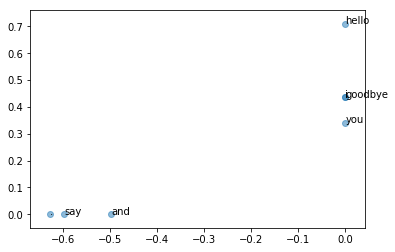

In [54]:
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

SVD의 계산은 O(N**3)의 복잡도를 자랑하므로, 보통은 특이값이 작은 것은 모두 버리는 Truncated SVD를 사용한다.

이제 PTB 데이터셋을 사용해 보자.

In [70]:
# Penn Treebank
import sys
import os

module_path = os.path.abspath(".")

from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
print('corpus size: ', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]', id_to_word[0])
print('id_to_word[1]', id_to_word[1])
print('id_to_word[2]', id_to_word[2])
print()
print('word_to_id["car"]', word_to_id['car'])
print('word_to_id["apple"]', word_to_id['apple'])
print('word_to_id["lexus"]', word_to_id['lexus'])

corpus size:  929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0] aer
id_to_word[1] banknote
id_to_word[2] berlitz

word_to_id["car"] 3856
word_to_id["apple"] 1410
word_to_id["lexus"] 7426


In [72]:
# PTB 데이터셋으로 평가
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting co-occurence...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI...')
W = ppmi(C, verbose=True)

print('calculatin SVD...')
try:
    # truncated SVD
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    # SVD(SLOW)
    U, S, V = np.linalg.svd(W)

counting co-occurence...
calculating PPMI...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.0% d

In [73]:
word_vecs = U[:, :wordvec_size]

queries = ['you', 'year', 'car', 'toyota']
for query in queries:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
i: 0.84230
we: 0.82731
they: 0.70114
there: 0.53437
anybody: 0.52751

[query] year
week: 0.81634
month: 0.80834
day: 0.68472
quarter: 0.66491
july: 0.65993

[query] car
auto: 0.70513
truck: 0.66186
jewelry: 0.59510
luxury-car: 0.58530
disk-drive: 0.58326

[query] toyota
kuwait: 0.67787
aeroflot: 0.61107
itel: 0.60487
pakistan: 0.60051
bullets: 0.57280
